In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_validate, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score

## Import data

In [2]:
data_df= pd.read_csv("../raw_data/churn_df_underbalanced.csv")

In [3]:
data_df = data_df.sample(frac=1, random_state=42)

In [4]:
data_df = data_df.drop(['Unnamed: 0','msno', 'bd', 'payment_method_id', 'city', 'registered_via'], axis=1)

## Which scaler to use for which feature

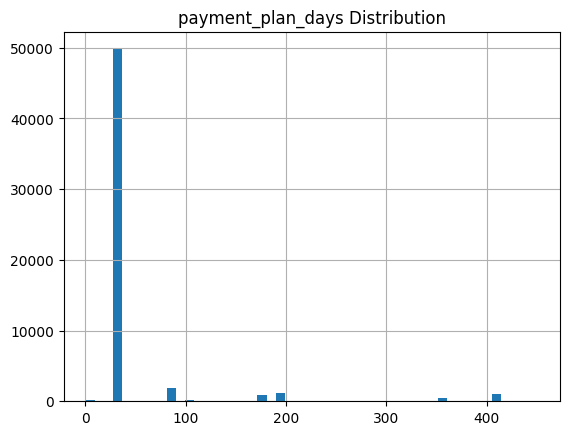

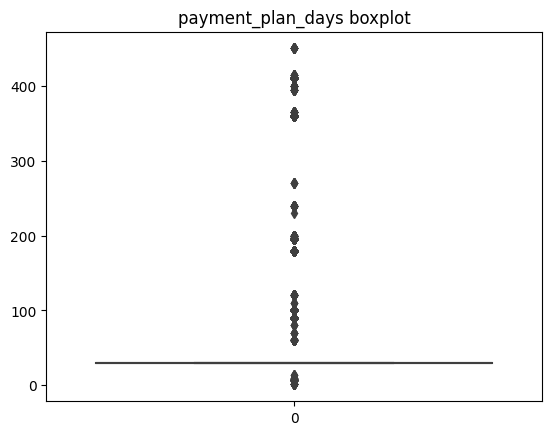

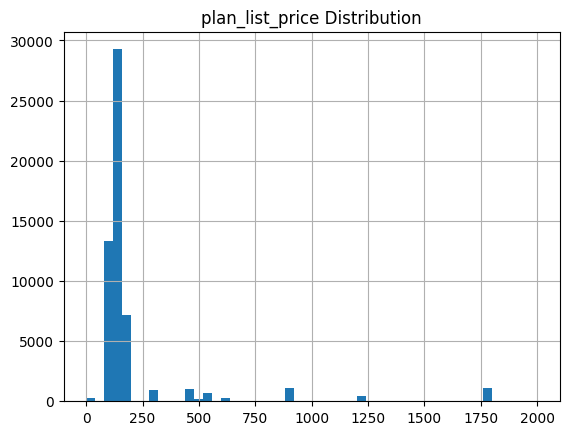

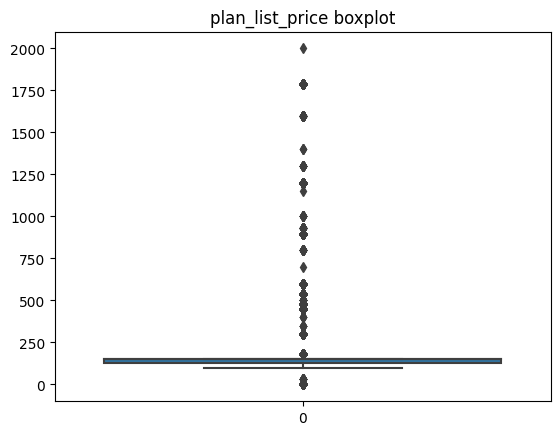

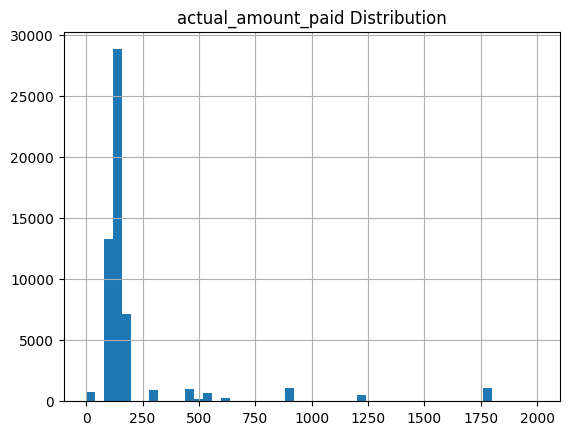

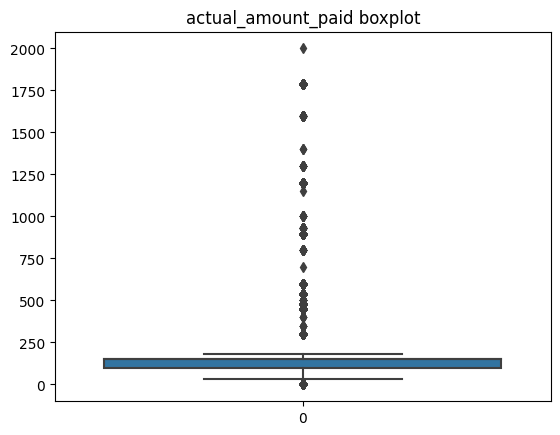

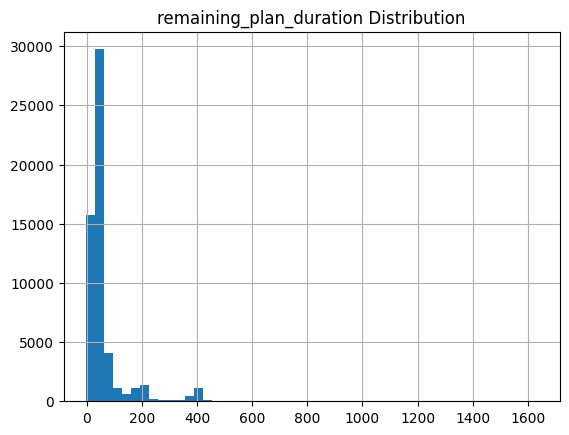

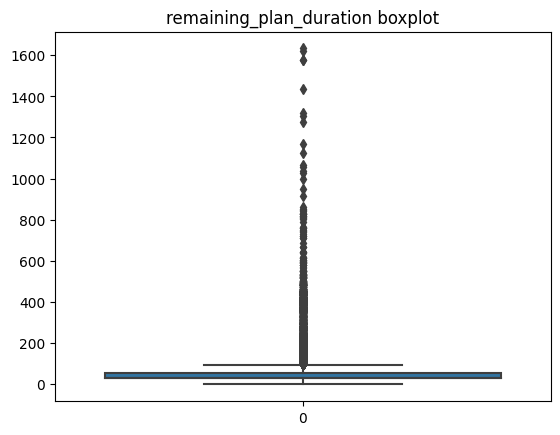

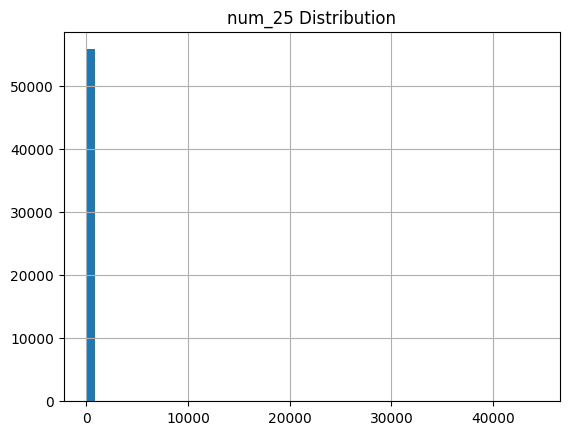

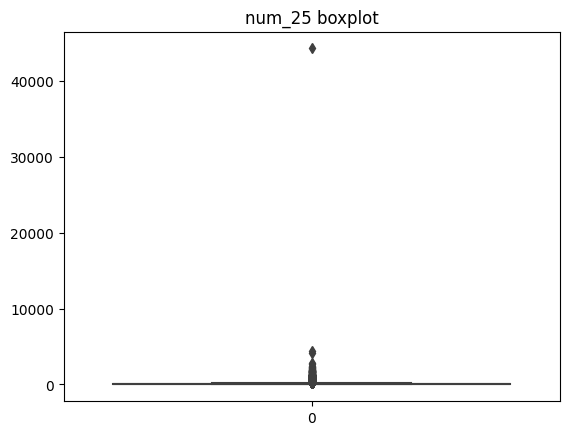

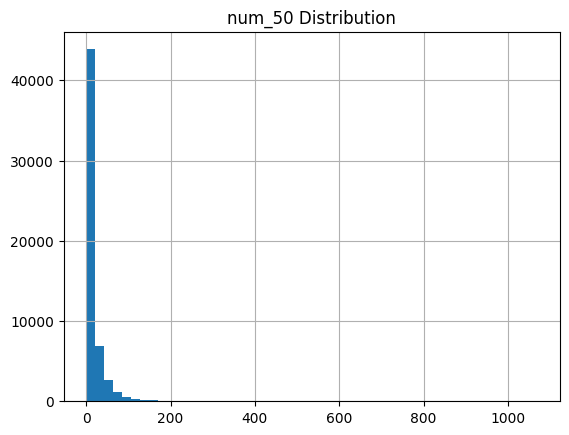

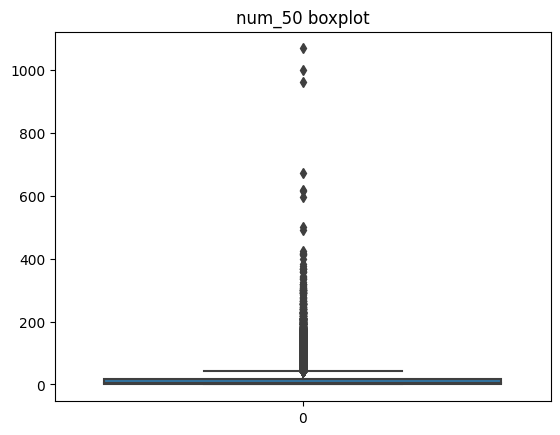

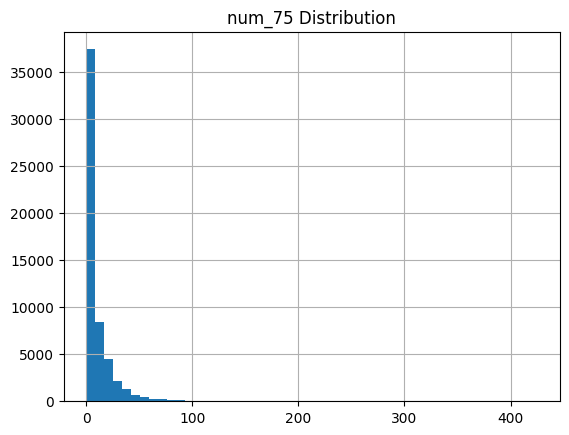

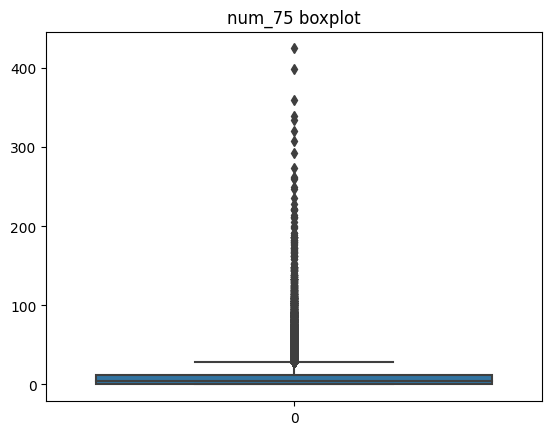

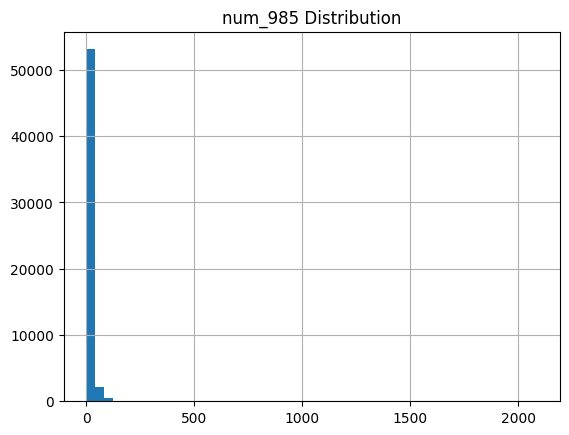

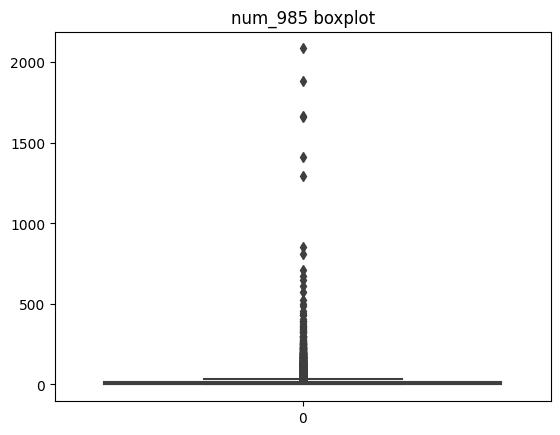

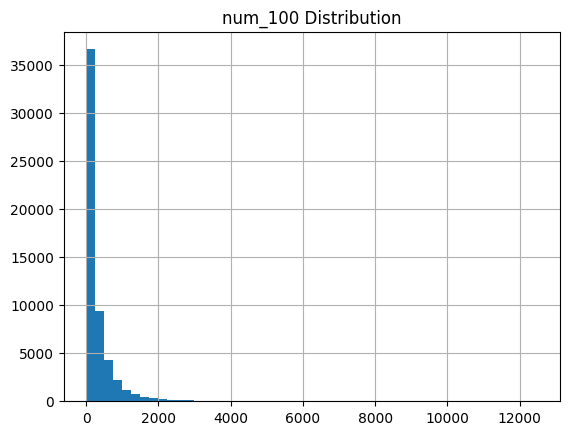

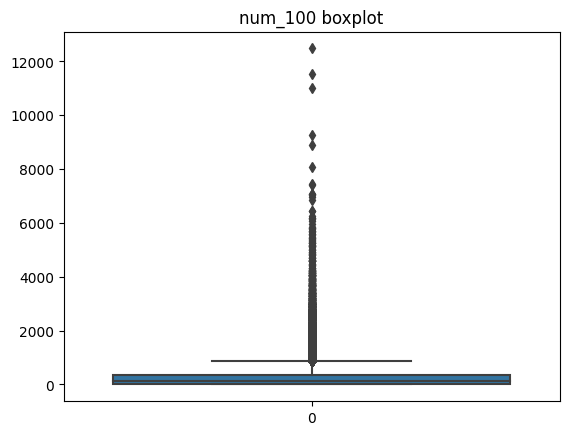

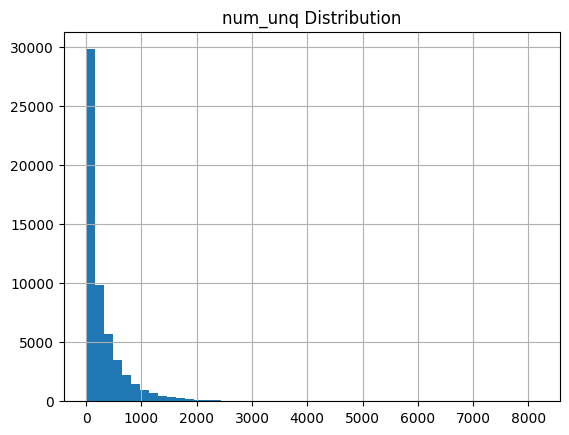

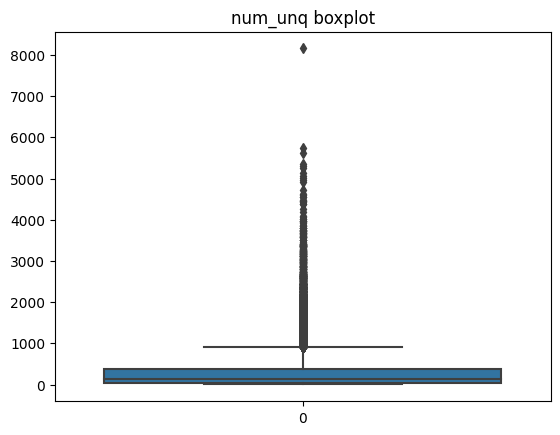

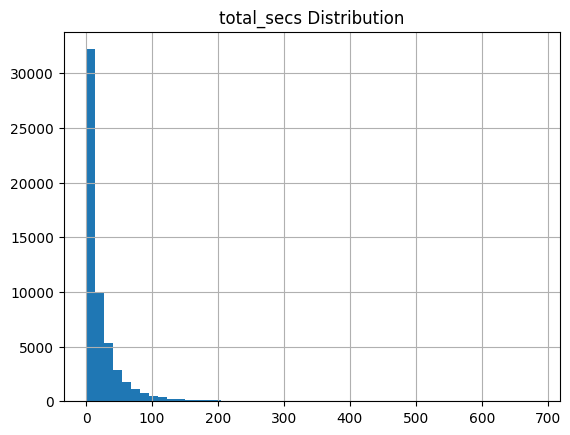

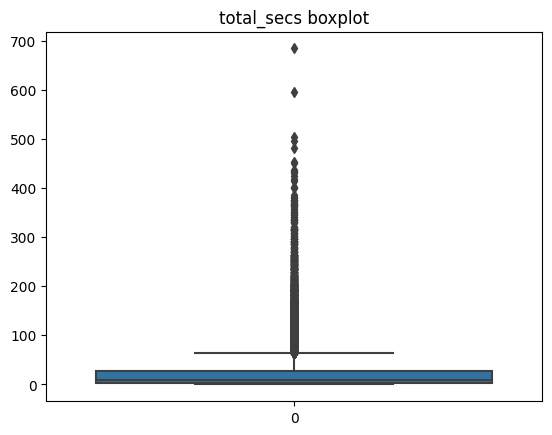

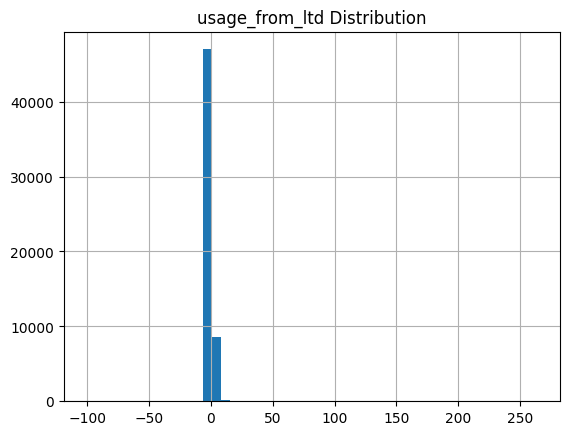

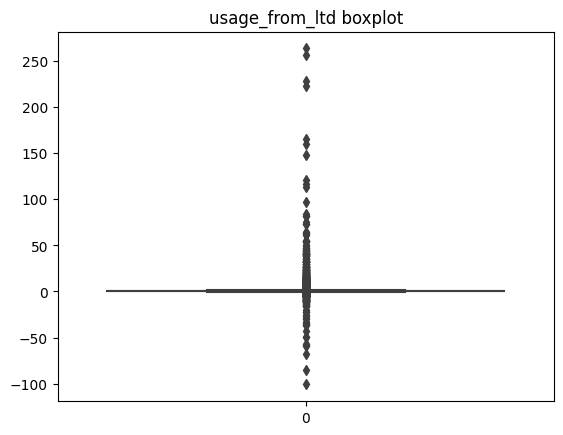

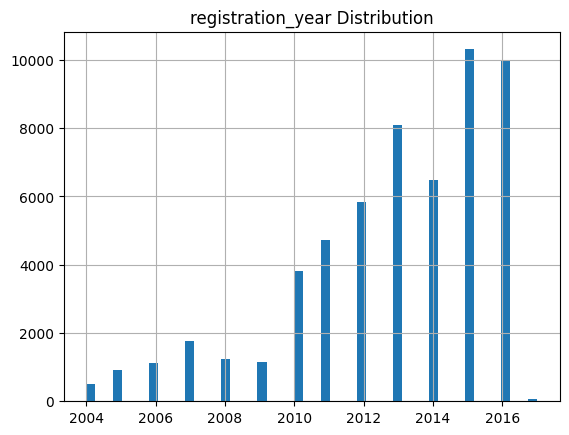

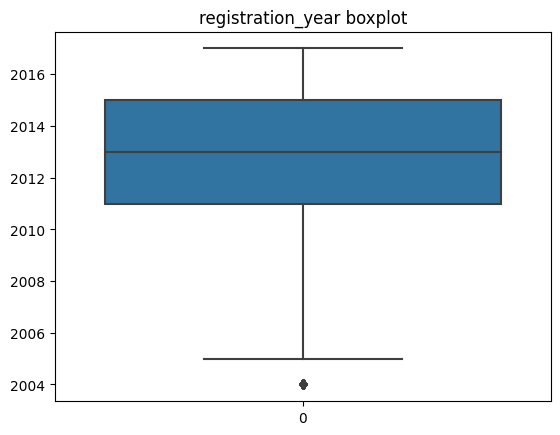

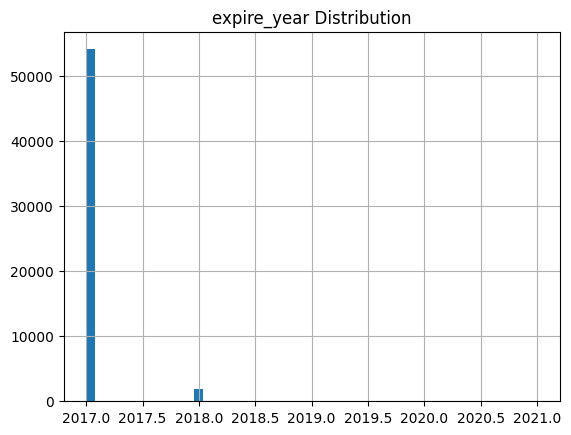

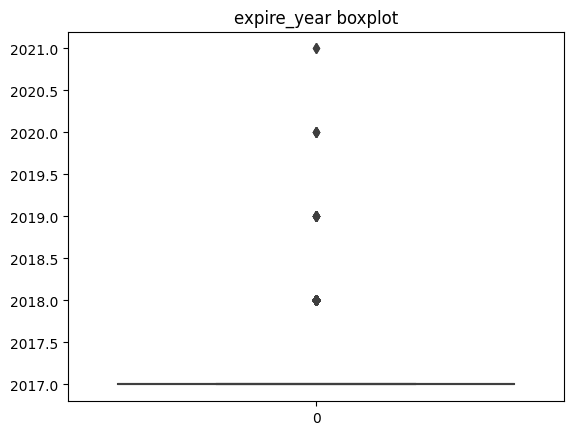

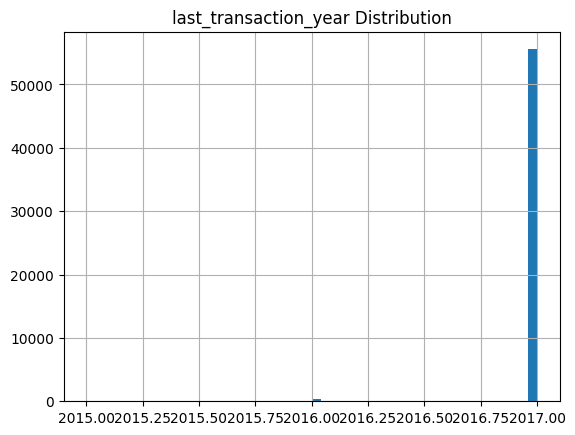

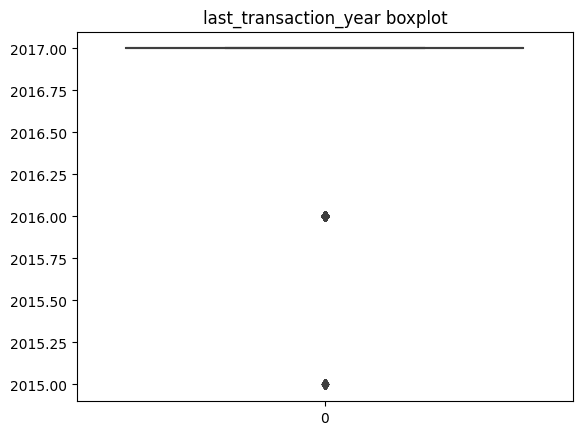

In [43]:
# for i in scale_features:
#     data_df[i].hist(bins=50)
#     plt.title(f'{i} Distribution')
#     plt.show()

#     sns.boxplot(data_df[i])
#     plt.title(f'{i} boxplot')
#     plt.show()

In [5]:
robust_features = [               'remaining_plan_duration', 
          'usage_from_ltd',
              'payment_plan_days',
              'plan_list_price',
              'actual_amount_paid',
             'num_50',
              'num_75',
              'num_985',
              
              'expire_year',
              'last_transaction_year'
             ]
minmax_features = ['registration_year']
normal_features = [ 'num_25',
              
              'num_100',
              'num_unq',
              'total_secs',]

In [46]:
# for feature in outliers:
#     data_df[feature] = np.log1p(data_df[feature])

In [47]:
# for i in scale_features:
#     data_df[i].hist(bins=50)
#     plt.title(f'{i} Distribution')
#     plt.show()

#     sns.boxplot(data_df[i])
#     plt.title(f'{i} boxplot')
#     plt.show()

## Pipeline

In [6]:
# Build the pipeline with the different steps
robust_pipeline = make_pipeline(RobustScaler())
minmax_pipeline = make_pipeline(MinMaxScaler())
log_pipeline = make_pipeline( 
    FunctionTransformer(np.log1p, validate=True),
    StandardScaler())

preprocessor_new = ColumnTransformer(
    transformers=[
        ('Robust', robust_pipeline, robust_features),
        ('MinMax', minmax_pipeline, minmax_features),
        ('Log', log_pipeline, normal_features)
    ], remainder='passthrough'
)
    


In [7]:
preprocessor_new

ColumnTransformer(remainder='passthrough',
                  transformers=[('Robust',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['remaining_plan_duration', 'usage_from_ltd',
                                  'payment_plan_days', 'plan_list_price',
                                  'actual_amount_paid', 'num_50', 'num_75',
                                  'num_985', 'expire_year',
                                  'last_transaction_year']),
                                ('MinMax',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['registration_year']),
                                ('Log',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>,
                                                                      validate=True)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['num_25', 'num_100', 'num_unq',
                                  'total_secs'])])

In [8]:
#create X and y
X = data_df.drop(['is_churn'], axis=1)
y= data_df['is_churn']

In [9]:
# Use fit on X_train and then transform both datasets
preprocessor_new.fit(X)
X_train_transformed = preprocessor_new.transform(X)

In [10]:
# Convert transformed data back to DataFrame to ensure column order is maintained
X_train_transformed = pd.DataFrame(
    X_train_transformed, 
    columns=X.columns
)

## XGBoost Classifier

In [18]:
xgb_clas = XGBClassifier()

cv_results = cross_validate(model, X_train_transformed, y, cv=5, scoring='precision')

precision_xgb = cv_results['test_score'].mean()

warnings.filterwarnings('ignore')

In [19]:
precision_xgb

0.9619372675364289

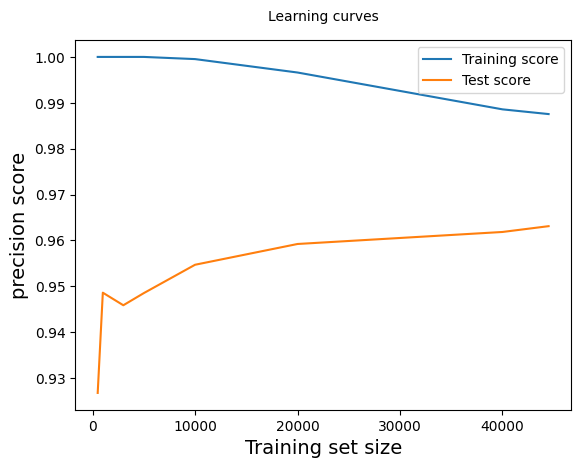

In [20]:
#learning curves for all features with xgboost

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000, 44500]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=xgb_clas, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

warnings.filterwarnings('ignore')

## Random forest 

In [23]:
randomforest = RandomForestClassifier()

cv_results = cross_validate(model, X_train_transformed, y, cv=5, scoring='precision')

precision_random_forest = cv_results['test_score'].mean()

warnings.filterwarnings('ignore')

In [24]:
precision_random_forest

0.964603879632198

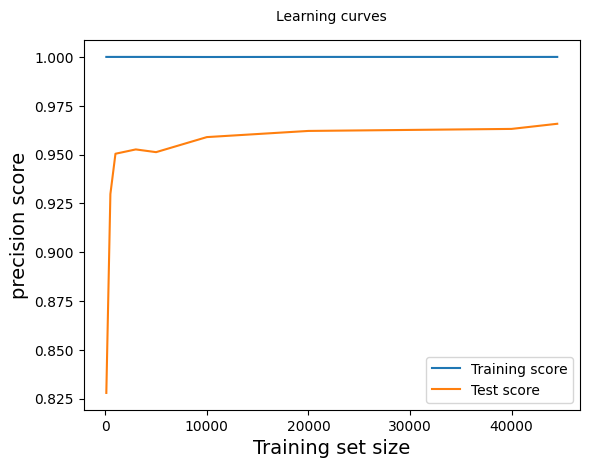

In [25]:
#learning curves for all features with xgboost

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000, 44500]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=randomforest, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

warnings.filterwarnings('ignore')

## Logistic Regresssion model

In [26]:
model = LogisticRegression(C= 2.58069,
                           solver='liblinear',
 max_iter= 2,
penalty= 'l1',
 class_weight= 'balanced')

model_no_hyperparams = LogisticRegression()

cv_results = cross_validate(model, X_train_transformed, y, cv=5, scoring='precision')

precision = cv_results['test_score'].mean()

warnings.filterwarnings('ignore')


In [22]:
cv_results

{'fit_time': array([0.05819106, 0.04439092, 0.03769994, 0.03544402, 0.03870082]),
 'score_time': array([0.00456882, 0.00373888, 0.00837588, 0.00688004, 0.00367212]),
 'test_score': array([0.9648227 , 0.96770601, 0.9591465 , 0.95995612, 0.97791885])}

In [12]:
precision

0.9655700284731694

## Learning curves for all features

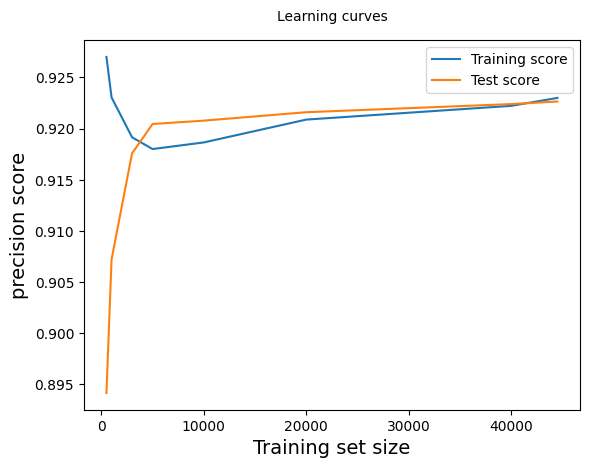

In [27]:
#learning curves for all features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000, 44500]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_no_hyperparams, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

warnings.filterwarnings('ignore')


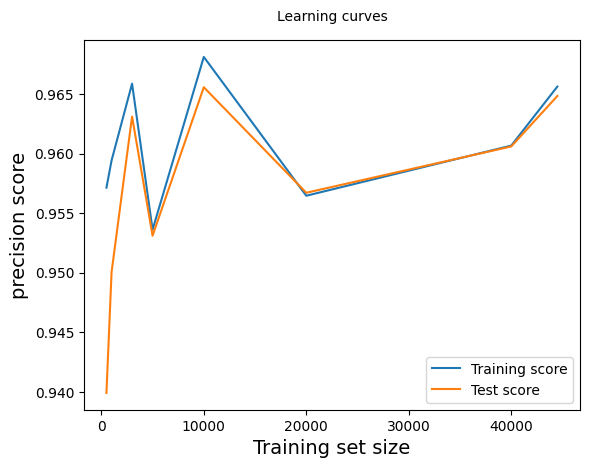

In [26]:
#learning curves for all features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000, 44500]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

warnings.filterwarnings('ignore')


In [13]:
model_random = LogisticRegression(C= 2.58069,
 solver= 'liblinear',
 max_iter= 10,
penalty= 'l2',
 class_weight= 'balanced')

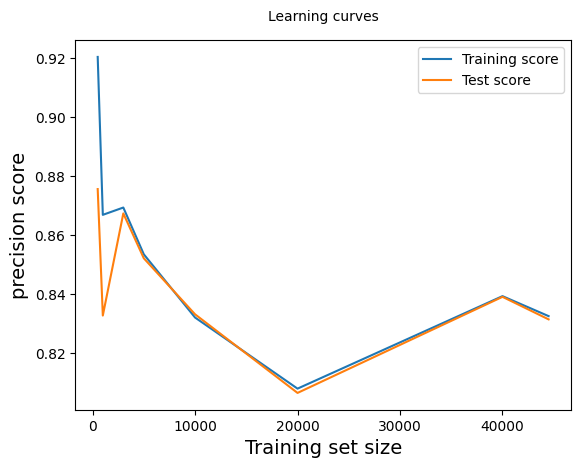

In [14]:
#learning curves for all features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000, 44500]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model_random, 
    X=X_train_transformed, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Learning curves for 15 features

In [17]:
#feature importance top 15
model.fit(X_train_transformed, y)
coefficients = model.coef_[0]
top_15_features = np.argsort(np.abs(coefficients))[-15:][::-1]
feature_names = X_train_transformed.columns
top_15_features = feature_names[top_15_features].tolist()
top_15_features

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


['remainder__is_cancel',
 'Robust__remaining_plan_duration',
 'remainder__is_auto_renew',
 'Robust__plan_list_price',
 'remainder__expire_month_sin',
 'remainder__expire_month_cos',
 'remainder__expire_day_sin',
 'remainder__last_transaction_day_cos',
 'remainder__last_transaction_month_cos',
 'Robust__actual_amount_paid',
 'remainder__last_transaction_day_sin',
 'remainder__is_discount',
 'remainder__discount_percentage',
 'Robust__num_25',
 'remainder__registration_month_cos']

In [18]:
#take only top 15 features
X_train_transformed_top_15 = X_train_transformed[top_15_features]


/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

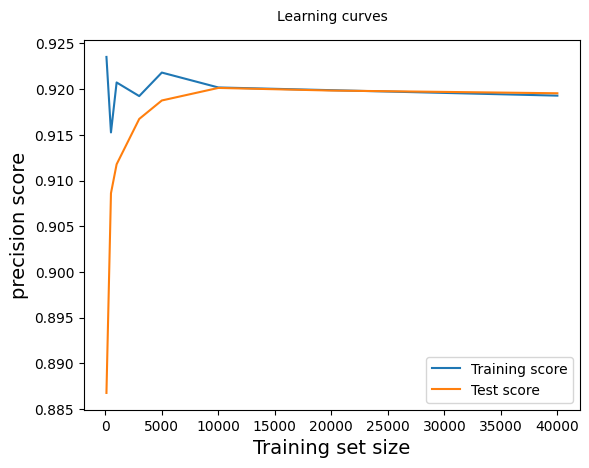

In [19]:
#learning curves for top 15 features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed_top_15, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True,
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Learning curves for 8 features

In [72]:
#feature importance top 8
model.fit(X_train_transformed, y)
coefficients = model.coef_[0]
top_8_features = np.argsort(np.abs(coefficients))[-8:][::-1]
feature_names = X_train_transformed.columns
top_8_features = feature_names[top_8_features].tolist()
top_8_features


['num_transformer__remaining_plan_duration',
 'remainder__is_cancel',
 'num_transformer__expire_year',
 'remainder__expire_month_cos',
 'remainder__discount_percentage',
 'remainder__expire_month_sin',
 'num_transformer__plan_list_price',
 'remainder__is_auto_renew']

In [73]:
#take only top 8 features
X_train_transformed_top_8 = X_train_transformed[top_8_features]

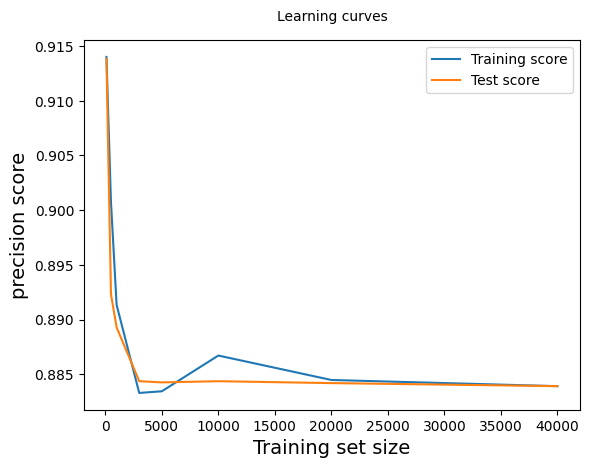

In [74]:
#learning curves with top 8 features

train_sizes = [100, 500, 1000, 3000, 5000, 10000, 20000, 40000]

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, 
    X=X_train_transformed_top_8, 
    y=y, 
    train_sizes=train_sizes,
    cv=5, 
    shuffle=True,
    scoring='precision'  # Set scoring to precision
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('precision score', fontsize=14)  # Change the ylabel to precision score
plt.xlabel('Training set size', fontsize=14)
plt.title('Learning curves', fontsize=10, y=1.03)
plt.legend()

## Random Search

In [97]:
#random search

param_distributions = {
    'C': uniform(loc=0, scale=4), 
    'solver': ['lbfgs', 'saga', 'newton-cg', 'liblinear',], 
    'penalty': ['l1', 'l2', 'none', 'elasticnet'],
    'max_iter': [1, 10, 50, 100], 
    'class_weight': ['none', 'balanced']
}

In [98]:
# Initialize the model
model = LogisticRegression()

# Initialize Random Search
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions,
    n_iter=100,  
    cv=5,      
    scoring='precision',  
    n_jobs=-1,  
    random_state=42,
    verbose=0 
)

# Fit data
random_search.fit(X_train_transformed, y)

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15e23dc90>,
                                        'class_weight': ['none', 'balanced'],
                                        'max_iter': [1, 10, 50, 100],
                                        'penalty': ['l1', 'l2', 'none',
                                                    'elasticnet'],
                                        'solver': ['lbfgs', 'saga', 'newton-cg',
                                                   'liblinear']},
                   random_state=42, scoring='precision')

In [99]:
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)

Best Parameters: {'C': 2.5806911616377994, 'class_weight': 'balanced', 'max_iter': 1, 'penalty': 'l1', 'solver': 'liblinear'}


## Grid Search

In [106]:
param_distributions = {
    'C': [2.58069],
    'solver': ['liblinear'], 
    'max_iter': [2,],
    'penalty': ['l1'],
    'class_weight': ['balanced']
}

In [104]:
# Initialize the model
logreg = LogisticRegression()

# Initialize Grid Search
grid_search = GridSearchCV(
    logreg, 
    param_grid=param_distributions,
    cv=5,        
    scoring='precision',  
    n_jobs=-1,   
    verbose=0 
)

# Fit data
grid_search.fit(X_train_transformed, y)

/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/xavier/.pyenv/versions/3.10.6/envs/Churn_prediction/lib/python3.10/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarnin

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [2.58069], 'class_weight': ['balanced'],
                         'max_iter': [1, 2, 3], 'penalty': ['l1'],
                         'solver': ['liblinear']},
             scoring='precision')

In [105]:
best_params_grid = grid_search.best_params_
best_model_grid = grid_search.best_estimator_

print("Best Parameters from Grid Search:", best_params_grid)

Best Parameters from Grid Search: {'C': 2.58069, 'class_weight': 'balanced', 'max_iter': 2, 'penalty': 'l1', 'solver': 'liblinear'}


## confusion matrix for basic logistic regression

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_new),
    ('classifier', model_no_hyperparams)
])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Robust',
                                                  Pipeline(steps=[('robustscaler',
                                                                   RobustScaler())]),
                                                  ['remaining_plan_duration',
                                                   'usage_from_ltd',
                                                   'payment_plan_days',
                                                   'plan_list_price',
                                                   'actual_amount_paid',
                                                   'num_50', 'num_75',
                                                   'num_985', 'expire_year',
                                                   'last_transaction_year']),
                                                 ('MinMax',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['registration_year']),
                                                 ('Log',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>,
                                                                                       validate=True)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['num_25', 'num_100',
                                                   'num_unq',
                                                   'total_secs'])])),
                ('classifier', LogisticRegression())])

In [33]:
full_pipeline.fit(X_train, y_train)
y_pred = full_pipeline.predict(X_test)

In [53]:
cm = confusion_matrix(y_test, y_pred)


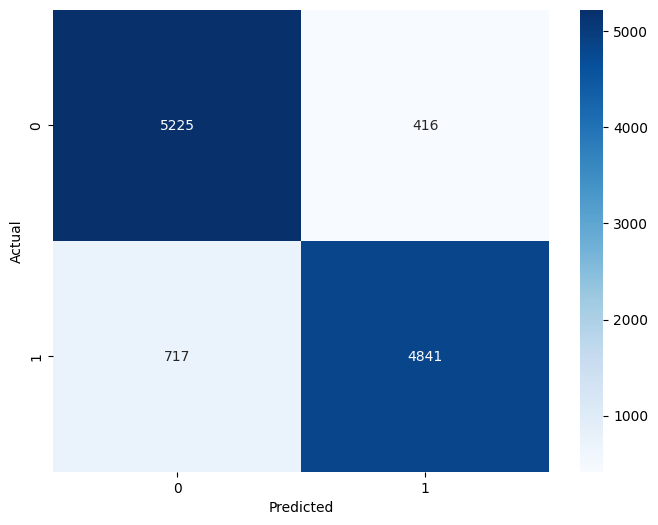

Accuracy: 0.898830252701134 = (TP+TN)/(TP+TN+FN+FP)
Precision: 0.9208674148754042 = TP/(TP+FP)
Recall: 0.8709967614249731 = TP/TP+FN
F1 Score: 0.8952380952380953 = 2 * precision *recall/(precision + recall)


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy} = (TP+TN)/(TP+TN+FN+FP)")
print(f"Precision: {precision} = TP/(TP+FP)")
print(f"Recall: {recall} = TP/TP+FN")
print(f"F1 Score: {f1} = 2 * precision *recall/(precision + recall)")

## confusion matrix for logistic regression with hyperparams


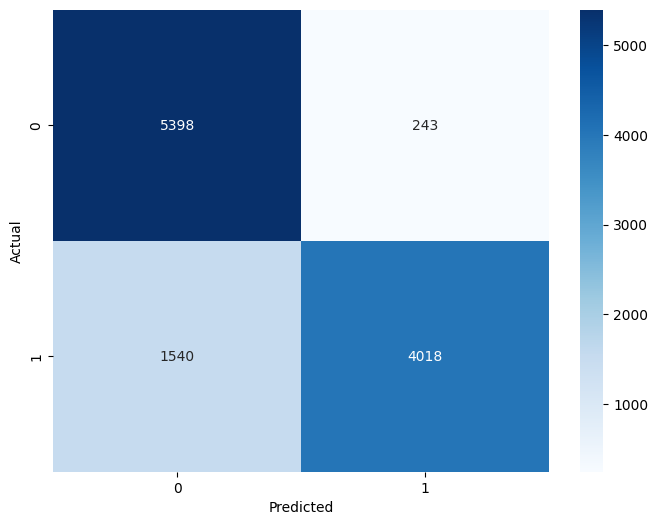

Accuracy_hp: 0.8407893561925172 = (TP+TN)/(TP+TN+FN+FP)
Precision_hp: 0.9429711335367285 = TP/(TP+FP)
Recall_hp: 0.7229219143576826 = TP/TP+FN
F1 Score_hp: 0.8184132803747836 = 2 * precision *recall/(precision + recall)


In [61]:
hyperparams_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_new),
    ('classifier', model)
])


hyperparams_pipeline.fit(X_train, y_train)
y_pred_hp = hyperparams_pipeline.predict(X_test)

cm_hyperparams = confusion_matrix(y_test, y_pred_hp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_hyperparams, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy_hp = accuracy_score(y_test, y_pred_hp)
precision_hp = precision_score(y_test, y_pred_hp)
recall_hp = recall_score(y_test, y_pred_hp)
f1_hp = f1_score(y_test, y_pred_hp)

print(f"Accuracy_hp: {accuracy_hp} = (TP+TN)/(TP+TN+FN+FP)")
print(f"Precision_hp: {precision_hp} = TP/(TP+FP)")
print(f"Recall_hp: {recall_hp} = TP/TP+FN")
print(f"F1 Score_hp: {f1_hp} = 2 * precision *recall/(precision + recall)")

In [70]:
model_random = LogisticRegression(penalty='l1')

random_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_new),
    ('classifier', model_random)
])


random_pipeline.fit(X_train, y_train)
y_pred_random = random_pipeline.predict(X_test)

random_hyperparams = confusion_matrix(y_test, y_pred_random)

plt.figure(figsize=(8, 6))
sns.heatmap(random_hyperparams, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

accuracy_random = accuracy_score(y_test, y_pred_random)
precision_random = precision_score(y_test, y_pred_random)
recall_random = recall_score(y_test, y_pred_random)
f1_random = f1_score(y_test, y_pred_random)

print(f"Accuracy_random: {accuracy_random} = (TP+TN)/(TP+TN+FN+FP)")
print(f"Precision_random: {precision_random} = TP/(TP+FP)")
print(f"Recall_random: {recall_random} = TP/TP+FN")
print(f"F1 Score_random: {f1_random} = 2 * precision *recall/(precision + recall)")

ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.